# Focus Radargram
This is a different method based off of the reccomended paper

In [1]:
import sys
sys.path.append("../")
from surface import *
from source import *
from model import *
import numpy as np
from time import time as Time

In [2]:
surf = Surface(origin=(0, 0), dims=(101, 101), fs=100)
surf.gen_flat(-10)

# source
ss = []
n = 200
for x in np.linspace(0, 10000, n):
    source = Source(1e-9, 0.5e-6, (x, 5050, 25000))
    source.chirp(9e6, 1e6)
    ss.append(source)

ms = []
st = Time()
for i, s in enumerate(ss):
    print(f"Simulating: {i+1}/{len(ss)} ({round(100*((i+1)/len(ss)), 1)}%)", end="     \r")
    model = Model(surf, s)
    model.set_target((5050, 5050, -200))    # set target location
    model.gen_raypaths()    # generate raypaths
    ms.append(model)
print(f"\n\nTotal processing time: {round((Time() - st)/60)} minutes and {round((Time() - st) % 60,2)} seconds")

Simulating: 200/200 (100.0%)     

Total processing time: 4 minutes and 12.63 seconds


## Generate reference function

In [3]:
# pull index of max transmittance per model
trs = [np.argmax([m.raypaths[i].tr for i in range(len(m.raypaths))]) for m in ms]
# find distance in air
rair = np.array([m.raypaths[t].mags[0] for t, m in zip(trs, ms)])
# find distance in ice
rice = np.array([m.raypaths[t].mags[1] for t, m in zip(trs, ms)])
# compute theta
theta = 2 * (rair + ms[0].nu2*rice) / ms[0].c
# compute ref function
reffun = np.exp(-1j*ss[0].wc*theta)

/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/srv/conda/envs/notebook/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


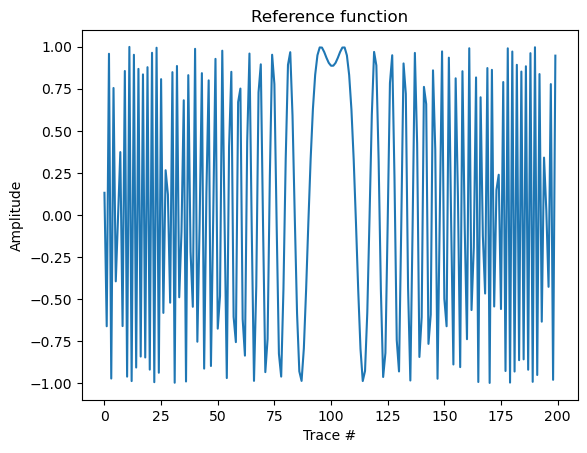

In [4]:
plt.plot(range(n), reffun)
plt.xlabel("Trace #")
plt.ylabel("Amplitude")
plt.title("Reference function")
plt.show()

In [5]:
N = 1000
x = np.linspace(0, 200, N)
irair = np.interp(x, np.arange(n), rair)
irice = np.interp(x, np.arange(n), rice)
# compute theta
itheta = 2 * (irair + ms[0].nu2*irice) / ms[0].c
# compute ref function
ireffun = np.exp(-1j*ss[0].wc*itheta)

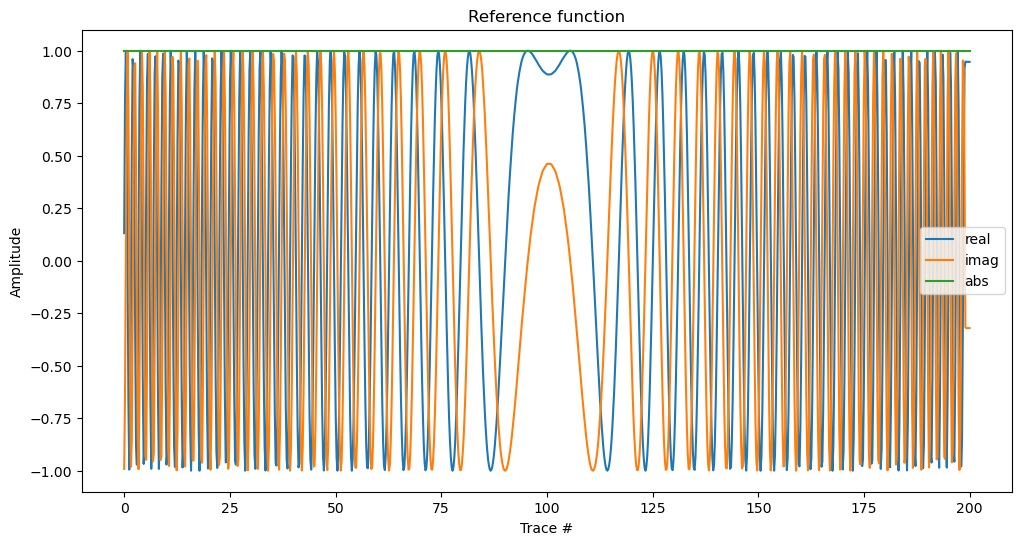

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x, np.real(ireffun), label="real")
ax.plot(x, np.imag(ireffun), label="imag")
ax.plot(x, np.abs(ireffun), label="abs")
ax.set_xlabel("Trace #")
ax.set_ylabel("Amplitude")
ax.set_title("Reference function")
ax.legend()
plt.show()

## Load radargram to focus

In [7]:
rdrgrm = np.load("../rdrgrm.npy")

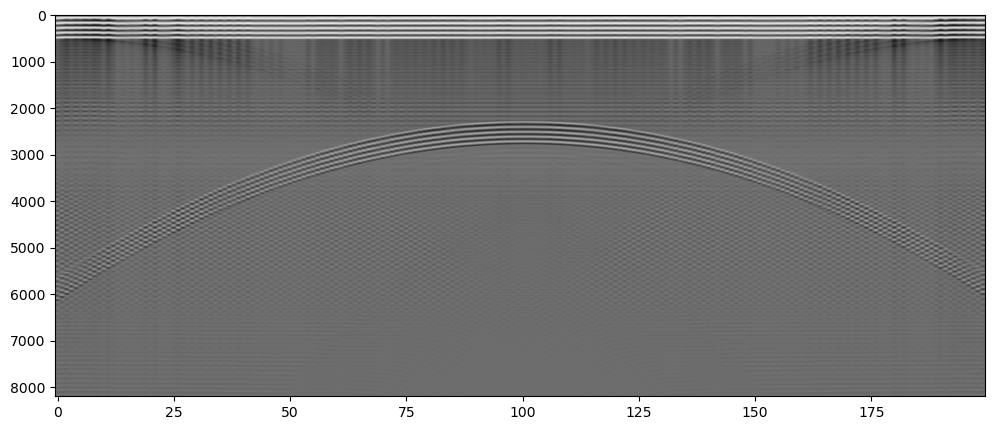

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(rdrgrm), cmap="grey", aspect=0.01)
plt.show()

## Range Compress

In [9]:
rc = np.zeros_like(rdrgrm)

for i in range(n):
    rc[:,i] = np.correlate(rdrgrm[:,i], ss[i].signal, mode='same')

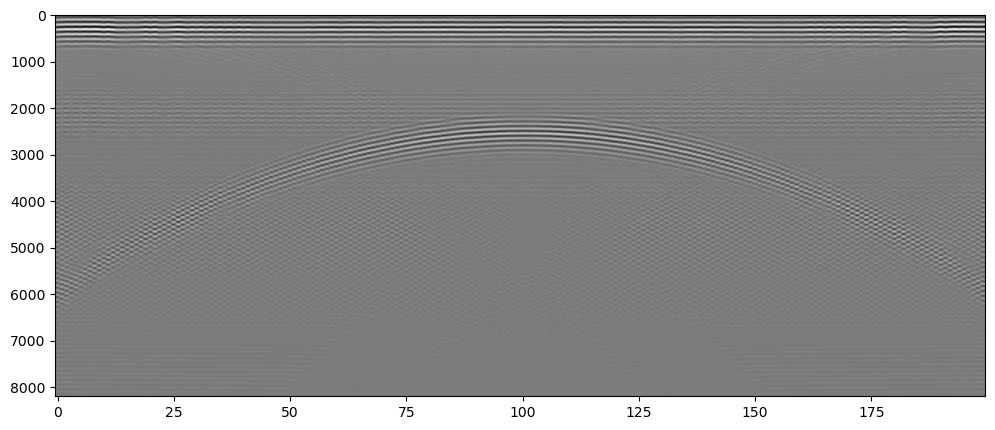

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(rc), cmap="grey", aspect=0.01)
plt.show()

## 1D Focusing

In [11]:
def focus1d(rdr, l1d, dx, dt, reffun):
    focused = np.copy(rdrgrm)
    reffun_conj = np.conjugate(reffun)
    st, en = 2000, 6000
    for ti in np.arange(st, en).astype(int):
        print(f"1D Focusing row: {ti+1}/{en}", end="    \r")
        for i, x in enumerate(np.arange(-1*l1d/2, l1d/2, dx)):
            focused[ti, i] = reffun_conj[i]*rdr[ti, i]*dx
    return focused

In [12]:
en = 10000
dx = en / n
focused1d = focus1d(rc, 10000, dx, 1e-9, reffun)

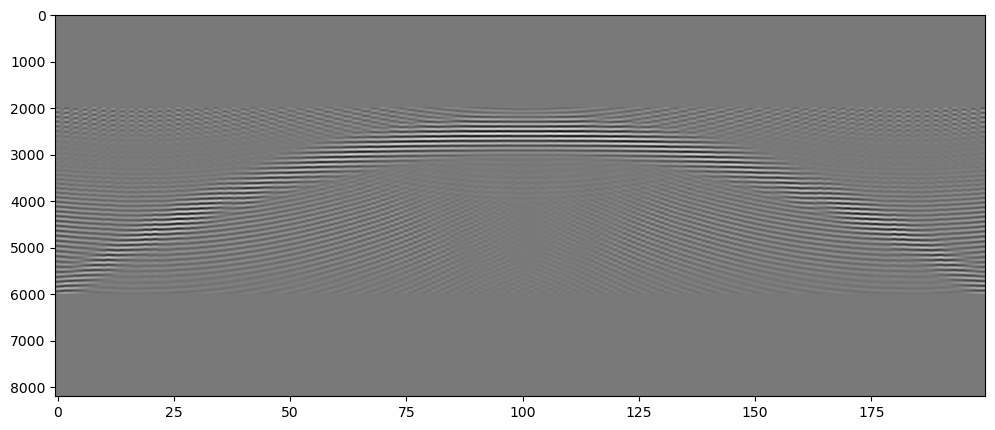

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(focused1d), cmap="grey", aspect=0.01)
plt.show()

## 2D Focusing

### Generate 2D reference function

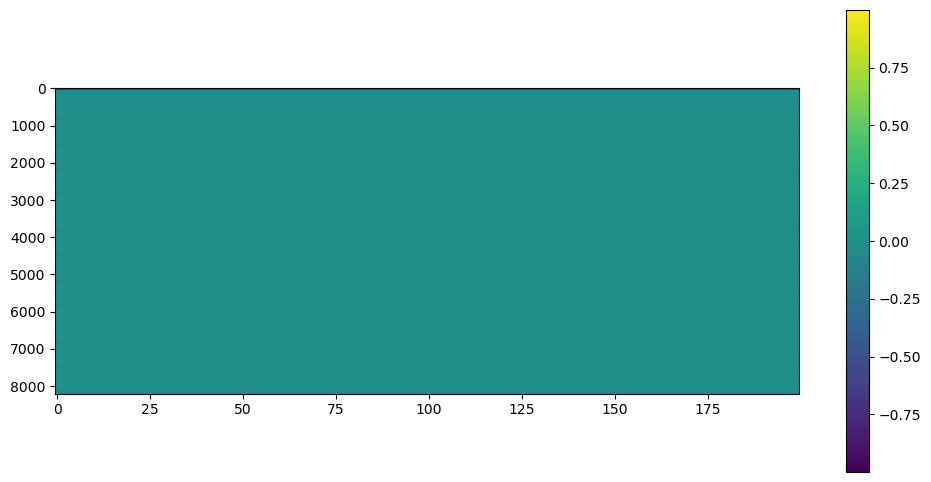

In [29]:
# time offset (start and end of radargram)
st = 166.8e-6   # start
en = 175e-6  # end

# find distance in air
rair = np.zeros(rc.shape)
for i, t in zip(range(n), trs):
    r = (np.arange(rair.shape[0]) * 1e-9 + st) * ms[0].c1 * 0.5
    rmax = ss[0].z + 10
    r[r > rmax] = rmax
    rair[:,i] = r
    
# find distance in ice
rice = np.zeros(rc.shape)
for i, t, m in zip(range(n), trs, ms):
    tair = (ss[0].z + 10) / ms[0].c1
    r = ((np.arange(rair.shape[0]) * 1e-9 + st) * 0.5 - tair) * ms[0].c2
    rice[:,i] = r
rice[rice < 0] = 0

# compute theta
theta = ((4 * np.pi) / ss[0].lam) * (rair + ms[0].nu2*rice)

# compute ref function
reffun = np.exp(-1j*theta)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im = ax.imshow(np.real(reffun), aspect=0.01)
plt.colorbar(im)
plt.show()

In [40]:
def focus2d(rdr, l2d, dx, dt, reffun):
    focused = np.copy(rdrgrm)
    reffun_conj = np.conjugate(reffun)
    st, en = 0000, rdr.shape[0]
    for ti in np.arange(st, en).astype(int):
        print(f"2D Focusing row: {ti+1}/{en}", end="    \r")
        for i, x in enumerate(np.arange(-1*l2d/2, l2d/2, dx)):
            focused[ti, i] = reffun_conj[ti, i]*rdr[ti, i]*dx*dt
    return focused

In [41]:
en = 10000
dx = en / n
focused2d = focus2d(rc, 10000, dx, 1e-9, reffun)

In [63]:
id = np.unravel_index(focused2d.argmax(), focused2d.shape)

In [64]:
id

(314, 8)

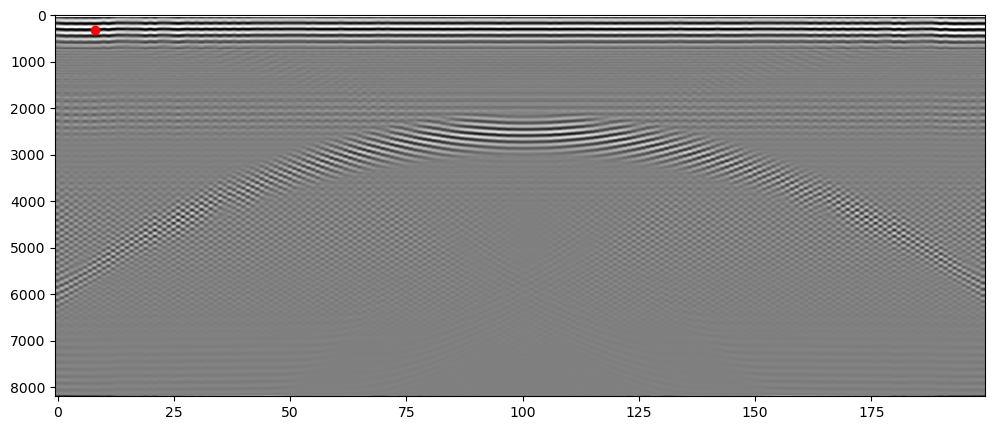

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(focused2d), cmap="grey", aspect=0.01, vmax=1e-7, vmin=-1e-7)
plt.scatter(id[1], id[0], color="red") 
plt.show()

# ATTEMPT 2

In [97]:
# load rdrgrm
rdrgrm = np.load("../rdrgrm.npy")

In [98]:
# Range compress
rc = np.zeros_like(rdrgrm)
for i in range(n):
    rc[:,i] = np.correlate(rdrgrm[:,i], ss[i].signal, mode='same')

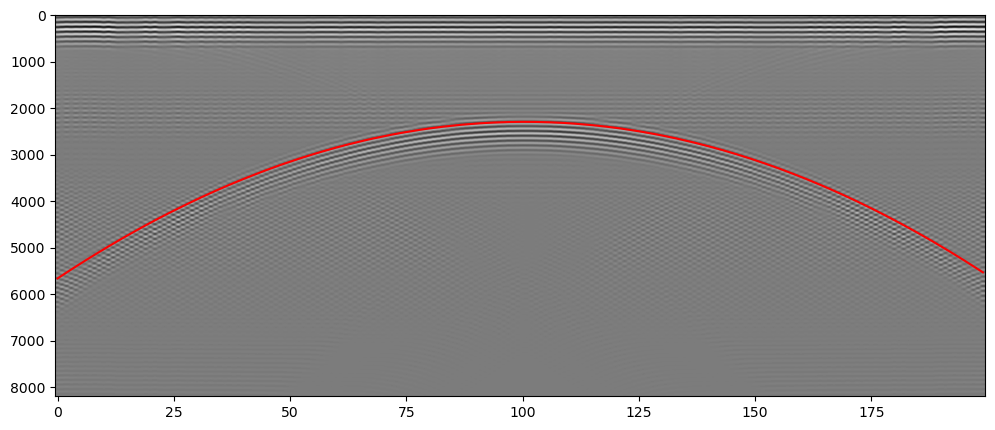

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(rc), cmap="grey", aspect=0.01)#, vmin=-5000, vmax=5000)
plt.plot(range(n), rngbins, color="red")
plt.show()

In [106]:
# shift azfft based on rcmc
rcmc = np.zeros_like(rc)
strngbin = int(np.min(rngbins))
for i, r in enumerate(rngbins):
    win = 2000
    section = rc[int(r-win):int(r+win),i]
    rcmc[:,i] = np.interp(range(0, rc.shape[0]), range(strngbin-win, strngbin+win), section)

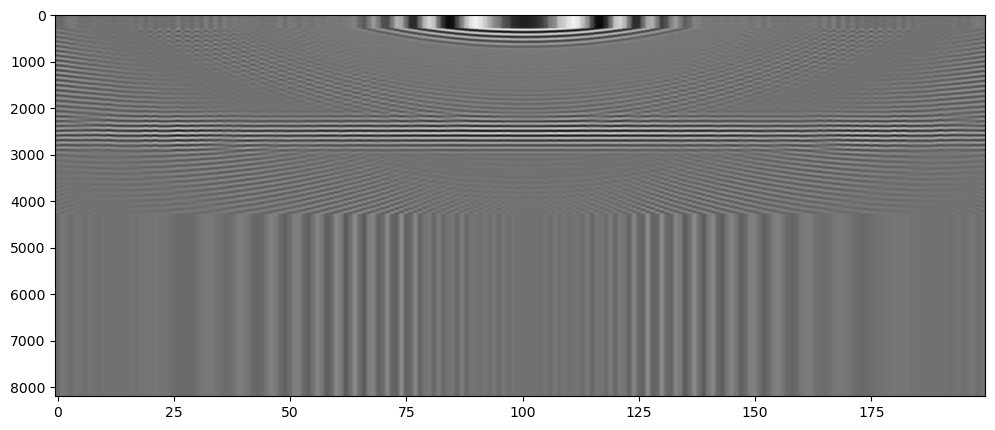

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(rcmc), cmap="grey", aspect=0.01)#, vmin=-5000, vmax=5000)
plt.show()

In [99]:
# azumith FFT
azfft = np.fft.fftshift(np.fft.fft(rc, axis=1), axes=1)

In [100]:
# rcmc
pathtimes = np.array([m.raypaths[t].path_time for t, m in zip(trs, ms)])
dt = 1e-9
rngbins = (pathtimes - st) // dt

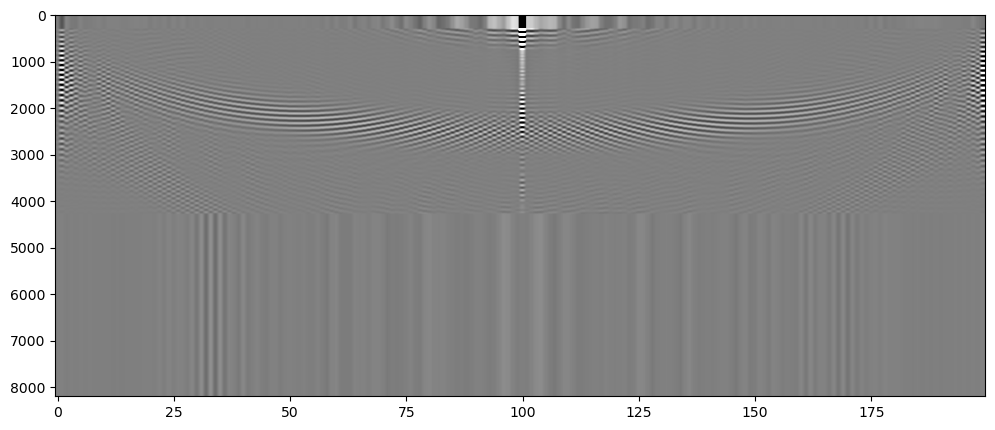

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(np.real(rcmc), cmap="grey", aspect=0.01, vmin=-5000, vmax=5000)
plt.show()